<a href="https://www.kaggle.com/code/alexeybulichev/titanic?scriptVersionId=190493156" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Описание проекта

**Обзор**

Данный проект направлен на предсказание выживаемости пассажиров "Титаника" с использованием машинного обучения. Проект включает два основных набора данных:

* Обучающий набор (train.csv): используется для построения и обучения моделей машинного обучения. В этом наборе данных предоставлен результат для каждого пассажира (выжил или нет), что позволяет моделям обучаться на реальных данных. Модель строится на основе различных характеристик пассажиров, таких как пол, возраст, класс билета и т.д. Возможна разработка новых характеристик для улучшения точности предсказаний.

* Тестовый набор (test.csv): используется для оценки эффективности модели на новых, невидимых данных. В этом наборе отсутствуют результаты для пассажиров, и задача состоит в том, чтобы предсказать, выжили ли они после крушения "Титаника", используя обученную модель.

* Дополнительно предоставлен файл gender_submission.csv, содержащий прогнозы, предполагающие, что все пассажиры женского пола выжили. Этот файл служит примером того, как должна выглядеть отправка результатов.

**Цель проекта**
Цель проекта — предсказать, выжил ли пассажир "Титаника" или нет, с использованием метрики `accuracy_score` для оценки точности модели.

**Словарь данных**
* survival: Выживание (0 = Нет, 1 = Да)
* pclass: Класс билетов (1 = 1-й, 2 = 2-й, 3 = 3-й)
* sex: Пол
* age: Возраст в годах
* sibsp: Количество братьев, сестер/супругов на борту "Титаника"
* parch: Количество родителей/детей на борту "Титаника"
* ticket: Номер билета
* fare: Стоимость проезда для пассажиров
* cabin: Номер каюты
* embarked: Порт отправления (C = Шербур, Q = Квинстаун, S = Саутгемптон)

**Примечания к переменным**
* pclass: Показатель социально-экономического статуса (SES)
1-й = Верхний
2-й = Средний
3-й = Нижний
age: Возраст указывается дробно, если он меньше 1 года. Если возраст оценивается, то указывается в формате xx.5

* sibsp: Количество братьев, сестер/супругов на борту. Определение семейных отношений:
Родной брат/сестра = брат, сестра, сводный брат, сводная сестра.
Супруг = муж, жена (любовницы и женихи не учитываются)

* parch: Количество родителей/детей на борту. Определение семейных отношений:
Родитель = мать, отец.
Ребенок = дочь, сын, падчерица, пасынок.
Некоторые дети путешествовали только с няней, поэтому для них показатель parch равен 0.

# Загрузка данных

In [1]:
!pip install catboost -q
!pip install shap -q
!pip install phik -q

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     RandomizedSearchCV)

from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler)

from sklearn.compose import ColumnTransformer


from sklearn.metrics import  accuracy_score

from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.inspection import permutation_importance

from sklearn.preprocessing import PolynomialFeatures

from catboost import CatBoostClassifier


from sklearn.impute import SimpleImputer

from sklearn.datasets import make_classification

from sklearn.pipeline import Pipeline

import shap

import phik


sns.set_style('darkgrid')
sns.set(font_scale=1.3)

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
target = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

train.name = 'train'
target.name = 'target'
test.name = 'test'

datas = [train, test, target]

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
target.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [6]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
for i in datas:
    print(f"-= {i.name} =-")
    i.info()
    print('_-' * 50)

-= train =-
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
-= test =-
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column    

Данные загруженны и открываются без ошибок.

# Обработка данных

Приводим все буквы к нижнему регистру для дальнейшего удобства в работе и анализа.

In [8]:
#  Приводим все буквы к нижнему регистру
train = train.applymap(lambda x: str(x).strip().lower() if isinstance(x, str) else x)
train.columns = train.columns.str.lower()

test = test.applymap(lambda x: str(x).strip().lower() if isinstance(x, str) else x)
test.columns = test.columns.str.lower()

target = target.applymap(lambda x: str(x).strip().lower() if isinstance(x, str) else x)
target.columns = target.columns.str.lower()

DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.


In [9]:
unique_values = ['pclass', 'sex', 'sibsp', 'parch', 'embarked']

for i in unique_values:
    print(f'Уникальные значения в DF -= train =- : {i}')
    print(' ')
    print(train[i].unique())
    print('_-'*25)

Уникальные значения в DF -= train =- : pclass
 
[3 1 2]
_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
Уникальные значения в DF -= train =- : sex
 
['male' 'female']
_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
Уникальные значения в DF -= train =- : sibsp
 
[1 0 3 4 2 5 8]
_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
Уникальные значения в DF -= train =- : parch
 
[0 1 2 5 3 4 6]
_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
Уникальные значения в DF -= train =- : embarked
 
['s' 'c' 'q' nan]
_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-


In [10]:
for i in unique_values:
    print(f'Уникальные значения в DF -= test =- : {i}')
    print(' ')
    print(test[i].unique())
    print('_-'*25)

Уникальные значения в DF -= test =- : pclass
 
[3 2 1]
_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
Уникальные значения в DF -= test =- : sex
 
['male' 'female']
_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
Уникальные значения в DF -= test =- : sibsp
 
[0 1 2 3 4 5 8]
_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
Уникальные значения в DF -= test =- : parch
 
[0 1 3 2 4 6 5 9]
_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
Уникальные значения в DF -= test =- : embarked
 
['q' 's' 'c']
_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-


Уникальные значения в train и test совпадают.


Количество пропусков в train:
passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64


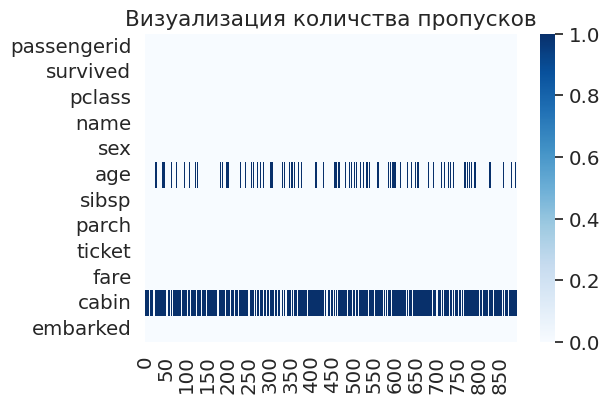

In [11]:
print(f'Количество пропусков в train:\n{train.isna().sum()}')
plt.figure(figsize=(6, 4))
sns.heatmap(train.isna().transpose(), cmap='Blues')
plt.title('Визуализация количства пропусков')
plt.show()

Количество пропусков в test:
passengerid      0
pclass           0
name             0
sex              0
age             86
sibsp            0
parch            0
ticket           0
fare             1
cabin          327
embarked         0
dtype: int64


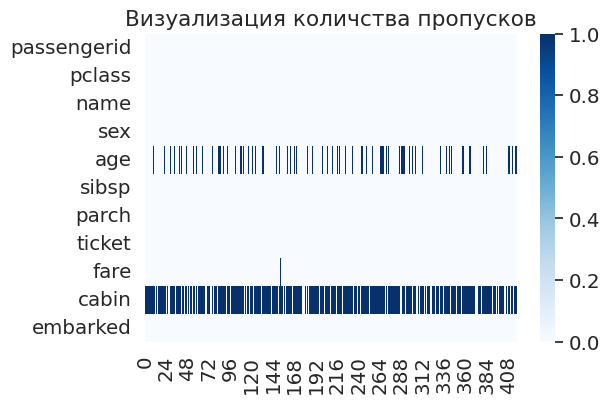

In [12]:
print(f'Количество пропусков в test:\n{test.isna().sum()}')
plt.figure(figsize=(6, 4))
sns.heatmap(test.isna().transpose(), cmap='Blues')
plt.title('Визуализация количства пропусков')
plt.show()


Очень большое количество пропусков в столбце `cabin`, данные востановить или привести к общему значению не имеет смысла, поэтому удалим этот столбец из за неинформативности. Так же есть пропуска в столбце `age`, заполним пропуска средним значением. Так же есть незначительное количество пропусков в столбце `fare`, поэтому там удалим сами строки с пропусками.

In [13]:
test = test.merge(target, on='passengerid')

train['age'] = train['age'].fillna(train['age'].median())
test['age'] = test['age'].fillna(test['age'].median())

Также удалим столбцы `name` и `ticket` из за неинформативности.

In [14]:
train = train.drop(['name','cabin', 'ticket', 'passengerid'], axis=1)
test = test.drop(['name','cabin', 'ticket', 'passengerid'], axis=1)

test.dropna(inplace=True)
train.dropna(inplace=True)

In [15]:
train['fare'] = train['fare'].astype('int')
test['fare'] = test['fare'].astype('int')

train['age'] = train['age'].astype('int')
test['age'] = test['age'].astype('int')

Количество пропусков в train:
survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64


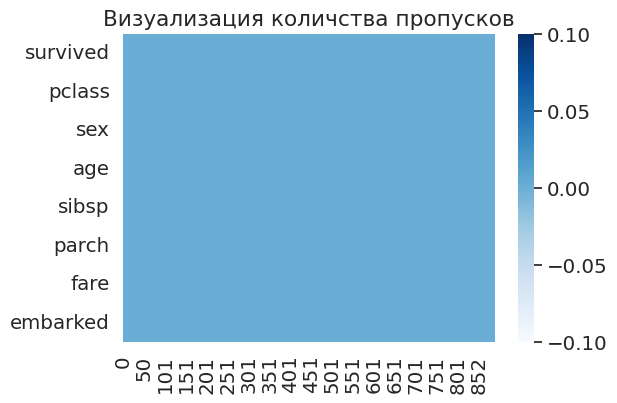

In [16]:
print(f'Количество пропусков в train:\n{train.isna().sum()}')
plt.figure(figsize=(6, 4))
sns.heatmap(train.isna().transpose(), cmap='Blues')
plt.title('Визуализация количства пропусков')
plt.show()


Количество пропусков в test:
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
survived    0
dtype: int64


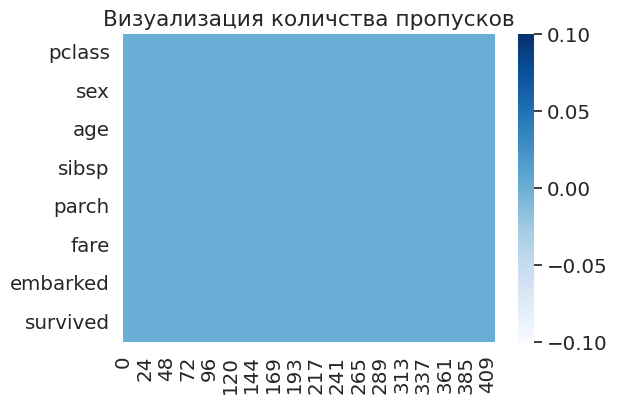

In [17]:
print(f'Количество пропусков в test:\n{test.isna().sum()}')
plt.figure(figsize=(6, 4))
sns.heatmap(test.isna().transpose(), cmap='Blues')
plt.title('Визуализация количства пропусков')
plt.show()

Проверим тренировочные данные на явные дубликаты, для этого удалим столбец `passengerid`, поскольку столбец неинформативен и дает уникальный номер каждому пассажиру.

In [18]:
#Функция для удаления дубликатов
def duplicat(data):
    print(data[data.duplicated()])
    print(f'размер df с дубликатами {data.shape}')
    print(f'Количество строк дубликатов: {data.duplicated ().sum()}')
    print(f'Процентное соотноешение пропусков: {round(data.duplicated().sum() / len(data) *100, 2)}%')
    data = data.drop_duplicates().reset_index(drop=True)
    print(f'размер df без дубликатов {data.shape}')
    return data.head()

In [19]:
duplicat(train)

     survived  pclass     sex  age  sibsp  parch  fare embarked
32          1       3  female   28      0      0     7        q
42          0       3    male   28      0      0     7        c
47          1       3  female   28      0      0     7        q
55          1       1    male   28      0      0    35        s
57          0       3    male   28      0      0     7        c
..        ...     ...     ...  ...    ...    ...   ...      ...
877         0       3    male   19      0      0     7        s
878         0       3    male   28      0      0     7        s
881         0       3    male   33      0      0     7        s
884         0       3    male   25      0      0     7        s
886         0       2    male   27      0      0    13        s

[197 rows x 8 columns]
размер df с дубликатами (889, 8)
Количество строк дубликатов: 197
Процентное соотноешение пропусков: 22.16%
размер df без дубликатов (692, 8)


,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22,1,0,7,s
1,1,1,female,38,1,0,71,c
2,1,3,female,26,0,0,7,s
3,1,1,female,35,1,0,53,s
4,0,3,male,35,0,0,8,s


Очень большое количество дубликатов 197 из 889, это 22.16% от общего количества данных. Удалим их, что бы модель бучилась более качественно.

**Промежуточный вывод:**

**Приведение букв к нижнему регистру:**

Все буквы приведены к нижнему регистру для дальнейшего удобства в работе и анализа данных. Это обеспечит консистентность и упростит последующую обработку данных.

**Проверка уникальных значений:**

Уникальные значения в тренировочном и тестовом наборах данных совпадают. Это говорит о том, что структура данных одинакова и дальнейшая обработка может быть выполнена одинаковыми методами для обоих наборов.

**Обработка пропусков:**

* Cabin: В столбце cabin обнаружено очень большое количество пропусков. Данные из этого столбца восстановить или привести к общему значению не имеет смысла из-за их неинформативности, поэтому было решено удалить этот столбец.

* Age: В столбце age также обнаружены пропуски. Пропуски в этом столбце были заполнены средним значением, что позволяет сохранить больше данных для анализа.

* Fare: В столбце fare обнаружено незначительное количество пропусков. Эти строки с пропусками были удалены, так как их количество незначительно и это не повлияет на качество анализа.

**Обработка дубликатов:**

* PassengerId: Столбец passengerid был удален перед проверкой на дубликаты, так как он неинформативен и служит только уникальным идентификатором для каждого пассажира.

* Удаление дубликатов: Было обнаружено значительное количество дубликатов — 197 из 889 строк, что составляет 22.16% от общего количества данных. Удаление дубликатов проведено для того, чтобы улучшить качество обучения модели, так как наличие дубликатов может негативно повлиять на ее производительность.


Таким образом, данные были предварительно обработаны, что позволит создать более качественную и точную модель для предсказания выживаемости пассажиров Титаника.

# Анализ данных

Построим графики по каждому признаку.

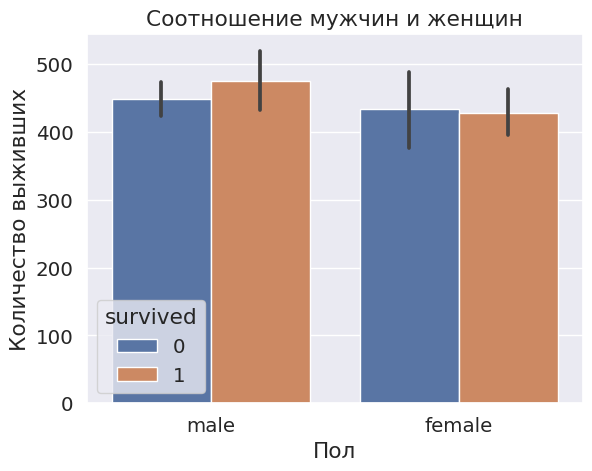

In [20]:
sns.barplot(x='sex', y=train.index, data=train, hue='survived');
plt.xlabel('Пол');
plt.ylabel('Количество выживших')
plt.title('Соотношение мужчин и женщин');

Соотношение выживших мужчин и женчин практически одинаковое.

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


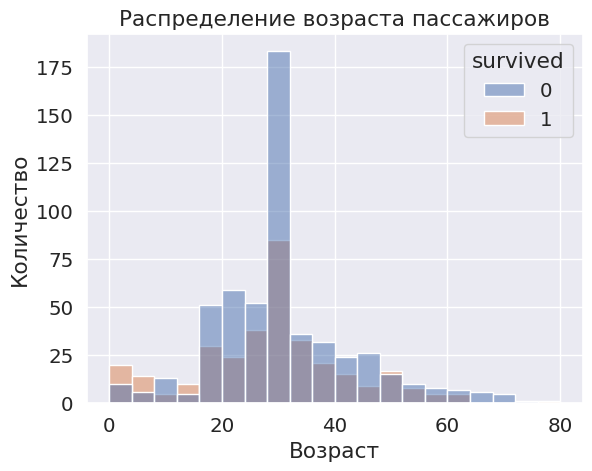

In [21]:
sns.histplot(x='age', data=train, hue='survived', bins=20);
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение возраста пассажиров');

Основной возраст пассажиров от 20 до 40 лет, виден высокий скачек на уровне 30 лет, так же большое количесво невыживших пассажиров в этой зоне, вероятно это заполненное среднее значение.

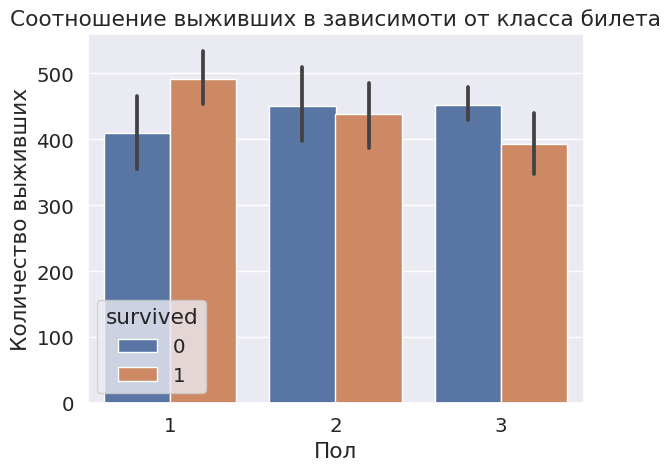

In [22]:
sns.barplot(x='pclass', y=train.index, data=train, hue='survived');
plt.xlabel('Пол');
plt.ylabel('Количество выживших')
plt.title('Соотношение выживших в зависимоти от класса билета');

Количество пассажиров с разными классами билетов практически одинаковая.

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


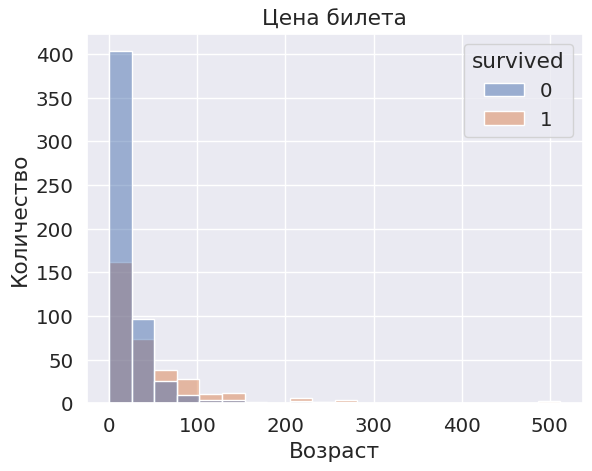

In [23]:
sns.histplot(x='fare', data=train, hue='survived', bins=20);
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Цена билета');

Видны выбросы. Построим "Ящик с усами" что бы детялнь посмотреть на них.

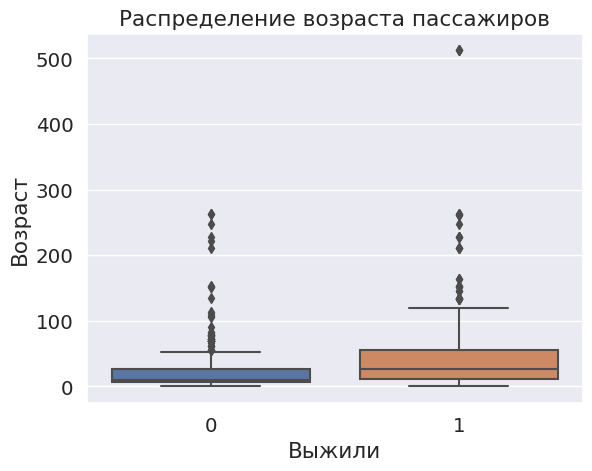

In [24]:
sns.boxplot(x='survived', y='fare', data=train);
plt.xlabel('Выжили')
plt.ylabel('Возраст')
plt.title('Распределение возраста пассажиров');

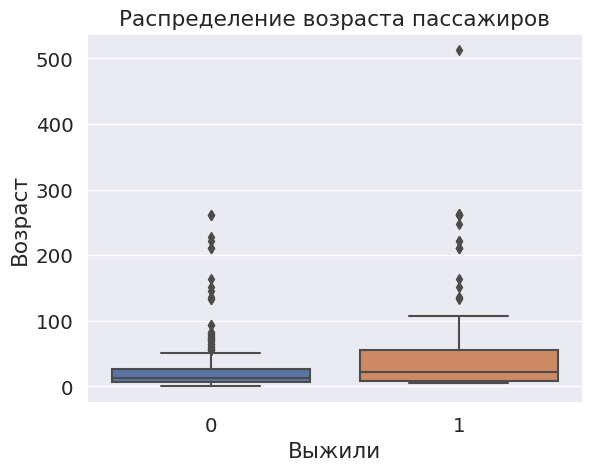

In [25]:
sns.boxplot(x='survived', y='fare', data=test);
plt.xlabel('Выжили')
plt.ylabel('Возраст')
plt.title('Распределение возраста пассажиров');

Виден один выброс в стоимости билета, как в тренировочных данныХ, так и в тестовых. Удалим его.

In [26]:
train = train.query('fare < 400')
test = test.query('fare < 400')

Проведем корреляционный анализ

**Промежуточный вывод.**


**Анализ полов и выживаемости:**
Соотношение выживших мужчин и женщин практически одинаковое. Это говорит о том, что пол пассажира не был главным фактором выживания.

**Анализ возрастных групп пассажиров:**
Основной возраст пассажиров составляет от 20 до 40 лет, с пиком на уровне 30 лет. Также видно большое количество невыживших пассажиров в этом возрастном диапазоне, что может свидетельствовать о том, что пропущенные значения в столбце возраста были заполнены средним значением.

**Анализ классов билетов:**
Количество пассажиров с разными классами билетов практически одинаковое. Это говорит о равномерном распределении пассажиров по классам на корабле.

**Обнаружение выбросов:**
Видны выбросы в данных, особенно в стоимости билетов. Как в тренировочных, так и в тестовых данных заметен один явный выброс в стоимости билета, который следует удалить для улучшения качества модели.

# Обучнение

In [27]:
R_S = 42

num_col = ['age', 'pclass', 'fare']

ohe_col = ['sex', 'embarked']

X_train = train.drop(['survived'] , axis=1)
y_train = train['survived']

X_test = test.drop(['survived'] , axis=1)
y_test = test['survived']

In [28]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy= 'most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

num_pipe = Pipeline(
    [
        ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy= 'mean')),
        ('num',StandardScaler())
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('num', num_pipe, num_col),
        ('ohe', ohe_pipe, ohe_col)
    ]
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=R_S))
])



In [29]:

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=R_S)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'models__min_samples_leaf': range(2, 15),
        'models__min_samples_split': range(2, 15),
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression()],
        'models__penalty': ['l2', None],
        'models__C': [0.01, 0.1, 1, 10, 100],
        'models__solver': ['newton-cg', 'lbfgs', 'sag'],
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression()],
        'models__penalty': ['l1', 'l2'],
        'models__C': [0.01, 0.1, 1, 10, 100],
        'models__solver': ['liblinear'],
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },
    {
        'models': [RandomForestClassifier(random_state=R_S)],
        'models__n_estimators': range(100, 300),
        'models__criterion': ['gini', 'entropy'],
        'models__max_depth': range(3, 30),
        'models__min_samples_split': range(2, 11),
        'models__min_samples_leaf': range(1, 5),
        'models__max_features': ['sqrt', 'log2'],
        'models__bootstrap': [True, False],
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },
    {
        'models': [CatBoostClassifier(silent=True, random_state=R_S)],
        'models__iterations': [100, 200, 300],
        'models__learning_rate': [0.01, 0.1, 0.2, 0.3],
        'models__depth': range(3, 7),
        'models__l2_leaf_reg': range(1, 8),
        'models__border_count': range(32, 100),
        'models__bagging_temperature': range(0, 3),
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },
    {
        'models': [SVC(random_state=R_S)],
        'models__C': [0.01, 0.1, 1, 10, 100],
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'models__degree': range(2, 5),
        'models__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10],
        'models__coef0': [0.0, 0.1, 0.5, 1.0],
        'preprocessor__num': [StandardScaler(), 'passthrough']
    }
]

In [30]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    scoring = 'accuracy',
    error_score='raise',
    random_state = R_S,
    n_jobs=-1,
    n_iter= 100,
    cv=5
)

In [31]:
randomized_search.fit(X_train, y_train);

In [32]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика лучшей модели:', round(randomized_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'pclass', 'fare']),
                                                 ('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sex', 'embarked'])])),
                ('models',
                 RandomForestClassifier(boots

In [33]:
best_model = randomized_search.best_estimator_

pred = best_model.predict(test.drop(['survived'] , axis=1))
print(f"Метрика тестовых данных: {round(accuracy_score(y_test, pred), 2)}")

Метрика тестовых данных: 0.86


**Вывод**

В ходе обучения модели для предсказания выживаемости пассажиров использовались кросс-валидация и пайплайн. Основные шаги и выводы из процесса обучения следующие:

**Предварительная обработка данных:**

* Для числовых признаков ('age', 'pclass', 'fare') применялись простое заполнение пропусков средним значением и стандартизация.
* Для категориальных признаков ('sex', 'embarked') применялись простое заполнение пропусков наиболее частыми значениями и one-hot кодирование.

**Модели:**

* Дерево решений (Decision Tree Classifier)
* Логистическая регрессия (Logistic Regression) с различными параметрами регуляризации и солверами.
* Случайный лес (Random Forest Classifier)
* CatBoost Classifier
* Support Vector Classifier (SVC)

**Поиск гиперпараметров:**

Для каждой модели подбирались оптимальные гиперпараметры с использованием RandomizedSearchCV, включая такие параметры, как глубина дерева, количество итераций, коэффициенты регуляризации и другие.

**Лучшая модель:**

Наилучшие результаты показала модель Random Forest Classifier с гиперпараметрами:
* bootstrap: False
* criterion: 'entropy'
* max_depth: 9
* min_samples_leaf: 3
* min_samples_split: 3
* n_estimators: 102

Метрика на тренировочных данных: 0.84

Метрика на тестовых данных: 0.86